In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns

## Generate data

1. A random sensing matrix with i.i.d. entries sampled from $\mathcal{N}(0, 1)$, $\mathbf{X} \in \mathbb{R}^{m \times d}$

2. $\boldsymbol{\xi} \in \mathbb{R}^{m}$ be a noise vector, independent of $\mathbf{X}$, with i.i.d. entries sampled from $\mathcal{N}(0, 1)$.
3. $\Theta = \{0, 1\}^{d}$ (signal space) and $\boldsymbol{\theta} \in \Theta$ (signal) be chosen uniformly at random and be independent of the pair $(\mathbf{X}, \boldsymbol{\xi})$.
4. Measurement vector $\mathbf{y} \in \mathbb{R}^{m}$

$$\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \boldsymbol{\xi}$$

In [3]:
def generate_data(m, d):
  X = np.random.randn(m, d)  # Sensing matrix
  xi = np.random.randn(m)   # Noise
  theta = np.random.randint(2, size=d)  # Signal
  y = X @ theta + xi  # Measurements
  return X, y, theta

## Define the likelihood and energy functions

The maximum likelihood estimate of $\boldsymbol{\theta}$ is given by the value $\widehat{\boldsymbol{\theta}} \in \Theta$ that minimizes the function

$$H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}) = -(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^{\top}(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})$$

given the observations $(\mathbf{X}, \mathbf{y})$.

In [4]:
def H(X, y, theta):
  return (y - X @ theta).T @ (y - X @ theta)

## Metropolis-Hastings algorithm

1. Set $\boldsymbol{\theta}_0 = \bar{\boldsymbol{\theta}}$.
2. For $t = 1, 2, \ldots, N - 1$:
   1. Pick $i$ uniformly at random in $\{1, 2, \ldots, d\}$.
   2. Let the proposed state be $\boldsymbol{\theta}^* \in \Theta$, with entries
      $\boldsymbol{\theta}^*(j) = \begin{cases}
          \boldsymbol{\theta}^{t-1}(j) & \text{if } j \neq i \\
          1 - \boldsymbol{\theta}^{t-1}(j) & \text{if } j = i
      \end{cases} \text{ for } j = 1, 2, \ldots, d.$
   3. Set
      $\boldsymbol{\theta}^t = \begin{cases}
          \boldsymbol{\theta}^* & \text{with probability } \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\} \\
          \boldsymbol{\theta}^{t-1} & \text{with probability } 1 - \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\}
      \end{cases}.$

In [5]:
def metropolis_hastings(X, y, beta, M, initial_theta):
  d = len(initial_theta)
  theta = initial_theta.copy()

  for _ in range(M):
    i = np.random.randint(d)
    theta_star = theta.copy()
    theta_star[i] = 1 - theta_star[i]

    acceptance_prob = min(1, np.exp(-beta * (H(X, y, theta_star) - H(X, y, theta))))

    if np.random.rand() < acceptance_prob:
      theta = theta_star

  return theta

## Result

### Experiment with different values of $\beta$

KeyboardInterrupt: 

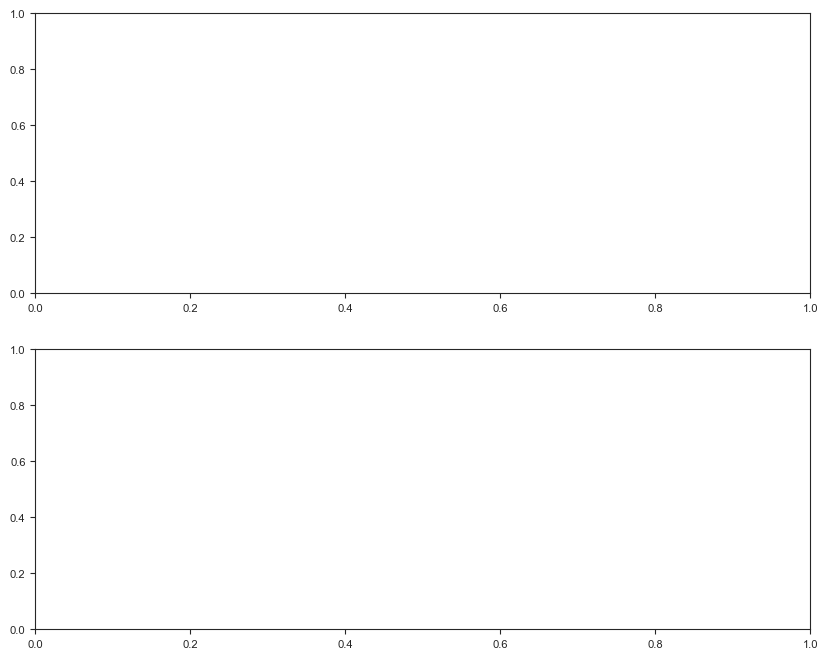

In [73]:
d = 10 
N = 1000 # Number of MCMC iterations
M = 10000 # Number of Metropolis-Hastings iterations
m_max = 15

beta_values = np.linspace(0.1, 2.0, 5)

# Set the style and font sizes
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

mse_plots = []
time_data = []

for beta in beta_values:
    ms = range(1, m_max + 1)
    MSEs = []
    times = []

    for m in ms:
        start_time = time.time()
        mse = 0
        for _ in range(N):
            X, y, theta_true = generate_data(m, d)
            initial_theta = np.random.randint(2, size=d)
            theta_hat = metropolis_hastings(X, y, beta, M, initial_theta)
            mse += ((theta_hat - theta_true).T @ (theta_hat - theta_true)) / M

        MSEs.append(mse)
        end_time = time.time()
        times.append(end_time - start_time)

    mse_plot = sns.lineplot(x=ms, y=MSEs, marker='o', ax=ax1, label=r'$\beta = {:.1f}$ , $M = {:.0f}$, $N = {:.0f}$, minimun MSE = {:.2f}'.format(beta,M,N,min(MSEs)))
    mse_plots.append(mse_plot)
    time_data.append({'beta': beta, 'Average Time': np.mean(times)})

# Plot average time by beta
time_df = pd.DataFrame(time_data)
time_plot = sns.lineplot(x='beta', y='Average Time', marker='s', data=time_df, ax=ax2)

# Show all values of m in the MSE plot
ax1.set_xticks(ms)
ax1.set_xticklabels(ms)

# Move the legend outside the box on the left side
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Set the x-axis label and ticks for the average time plot
ax2.set_xticks(beta_values)
ax2.set_xticklabels([r'$\beta = {:.1f}$'.format(beta) for beta in beta_values])
ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel("Average Time (s)")
ax2.grid(False)

# Remove the top and right spines
sns.despine()

plt.show()

## Experiment with different values of $M$

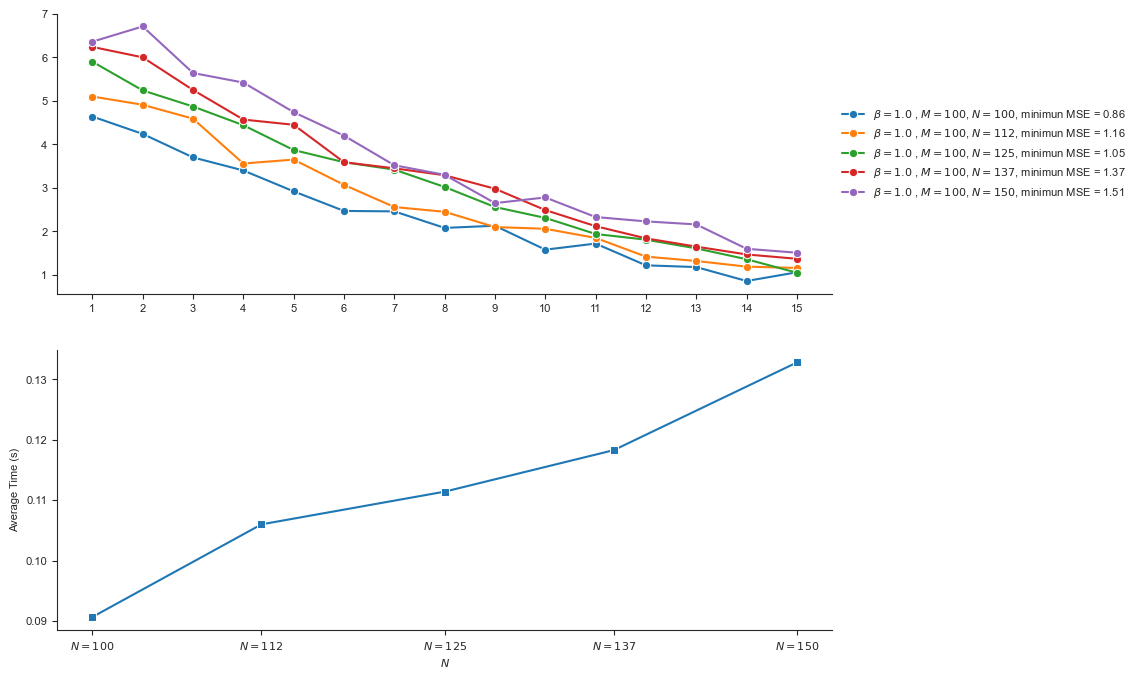

In [78]:
N_values = np.linspace(1000, 5000, 5, dtype=int) # Number of MCMC iterations
d = 10 
m_max = 15
M=100 # Number of Metropolis-Hastings iterations
beta = 1.0

# Set the style and font sizes
sns.set_style('ticks')
plt.rcParams.update({'font.size': 8})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

mse_plots = []
time_data = []

for N in N_values:
    ms = range(1, m_max + 1)
    MSEs = []
    times = []

    for m in ms:
        start_time = time.time()
        mse = 0
        for _ in range(N):
            X, y, theta_true = generate_data(m, d)
            initial_theta = np.random.randint(2, size=d)
            theta_hat = metropolis_hastings(X, y, beta, M, initial_theta)
            mse += ((theta_hat - theta_true).T @ (theta_hat - theta_true)) / M

        MSEs.append(mse)
        end_time = time.time()
        times.append(end_time - start_time)

    mse_plot = sns.lineplot(x=ms, y=MSEs, marker='o', ax=ax1, label=r'$\beta = {:.1f}$ , $M = {:.0f}$, $N = {:.0f}$, minimun MSE = {:.2f}'.format(beta,M,N,min(MSEs)))
    mse_plots.append(mse_plot)
    time_data.append({'N': N, 'Average Time': np.mean(times)})

# Plot average time by beta
time_df = pd.DataFrame(time_data)
time_plot = sns.lineplot(x='N', y='Average Time', marker='s', data=time_df, ax=ax2)

# Show all values of m in the MSE plot
ax1.set_xticks(ms)
ax1.set_xticklabels(ms)

# Move the legend outside the box on the left side
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Set the x-axis label and ticks for the average time plot
ax2.set_xticks(N_values)
ax2.set_xticklabels([r'$N = {:.0f}$'.format(N) for N in N_values])
ax2.set_xlabel(r'$N$')
ax2.set_ylabel("Average Time (s)")
ax2.grid(False)

# Remove the top and right spines
sns.despine()

plt.show()
